# **Import Modules**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import os
import time
from math import ceil
from datetime import datetime
from scipy.sparse.csgraph import laplacian
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import tensorflow as tf
from tensorflow.keras import backend as K, activations, initializers, constraints, regularizers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Layer, Dropout, LSTM, Dense, Permute, concatenate, Reshape, BatchNormalization
from tensorflow.keras.utils import Sequence

# **Prepare Data**

## Graph Features: Weighted adjacent matrix

In [3]:
def preprocess_adjacent_matrix(adj_matrix, normalized_k=0.1):

    # Calculates the standard deviation as theta.
    # adj_matrix = adj_matrix.to_numpy()
    distances = adj_matrix[~np.isinf(adj_matrix)].flatten()
    std = distances.std()
    adj_mx = np.exp(-np.square(adj_matrix / std))

    # Sets entries that lower than a threshold, i.e., k, to zero for sparsity.
    adj_mx[adj_mx < normalized_k] = 0
    return adj_mx

In [4]:
def get_adjacent_matrix(distance_file: str) -> np.array:
    """
    :param distance_file: str, '/content/drive/MyDrive/Phân tích dữ liệu lớn - DS200.N21/Data/distance.csv'
    :return: A ，np.array(N, N), N (int)
    """
    df = pd.read_csv(distance_file)
    A = df.pivot(index = 'from', columns = 'to', values = 'distance')
    A = A.rename_axis(None, axis=1)
    A = A.rename_axis(None, axis=0)
    A = np.array(A)
    A = preprocess_adjacent_matrix(A, normalized_k=0.1)
    n_nodes = A.shape[0]
    return A, n_nodes

## Node Features: traffic, news, weather

In [5]:
def get_node_features(features_file: str, time_len: int) -> np.array:
    """
    :param features_file: '/content/drive/MyDrive/Phân tích dữ liệu lớn - DS200.N21/Data/node_features.txt', data of node features
    :return: np.array(N, T, D)
    """

    node_features = np.loadtxt(features_file)
    node_features = node_features.reshape(65, time_len*24, 28)
    traffic = node_features[:,:,0]

    scaler = MinMaxScaler()
    norm_traffic = scaler.fit_transform(traffic.reshape(traffic.shape[1], traffic.shape[0]))
    norm_traffic = norm_traffic.reshape(traffic.shape[0], traffic.shape[1])

    return norm_traffic, scaler

In [6]:
class LoadData(Dataset):
    def __init__(self, path, num_nodes, divide_days, time_interval, seq_len, pre_len, train_mode, time_len):
        """
        :param path: '/content/drive/MyDrive/Phân tích dữ liệu lớn - DS200.N21/Data/node_features.txt', path to node features data
        :param num_nodes: int, number of nodes.
        :param divide_days: list, [ days of train data, days of val data, days of test data], list to divide the original data. [869, 110, 110]
        :param time_interval: int, time interval between two traffic data records (mins).
        :param seq_len: int, length of history data to be used.
        :param pred_len: int, length of predicted time series
        :param train_mode: list, ["train", "test"].
        :param features: number, [0: traffic + news + weather, 1: traffic + news, 2: traffic + weather]
        :param time_len: number, length of node features file
        """

        self.num_nodes = num_nodes # 65
        self.train_mode = train_mode
        self.train_days = divide_days[0]
        self.test_days = divide_days[1]
        self.seq_len = seq_len  # 7 days (168)
        self.pre_len = pre_len # 1 day (24)
        self.time_interval = time_interval  # 60 min
        self.one_day_length = int(24 * 60 / self.time_interval)
        self.time_len = time_len
        self.norm_features, self.scaler = get_node_features(path, time_len)

    def __len__(self):
        """
        :return: length of dataset (number of samples).
        """
        if self.train_mode == "train":
            return (self.train_days - (self.seq_len + self.pre_len)) * self.one_day_length + 1
        elif self.train_mode == "test":
            return (self.test_days - (self.seq_len + self.pre_len)) * self.one_day_length + 1
        else:
            raise ValueError("train mode: [{}] is not defined".format(self.train_mode))

    def __getitem__(self, index):  # (x, y), index = [0, L - (seq + pre - 1)]
        """
        :param index: int, range between [0, length - 1].
        :return:
            data_x: torch.tensor, [N, H, D].
            data_y: torch.tensor, [N, 1, D].
        """
        if self.train_mode == "train":
            index = index
        elif self.train_mode == "test":
            index = index + self.train_days * self.one_day_length
        else:
            raise ValueError("train mode: [{}] is not defined".format(self.train_mode))

        data_x, data_y = LoadData.slice_data(self.norm_features, self.seq_len*self.one_day_length, self.pre_len*self.one_day_length, index)

        data_x = LoadData.to_tensor(data_x)
        data_y = LoadData.to_tensor(data_y)

        return [data_x, data_y]

    @staticmethod
    def slice_data(data, seq_len, pre_len, index):
        """
        :param data: np.array, normalized node features data.
        :param seq_len: int, the number of timesteps up to the prediction feed to the model.
        :param pre_len: int, the amount of time in advance to be predicted.
        :param index: int, index on temporal axis.
        :return:
            x: np.array, [N, H, D], predictors
            y: np.array [N, D], predictions
        """

        a = data[:, index : index + (seq_len + pre_len)]
        x = a[:,:seq_len]
        y = a[:,-1]

        return x, y

    @staticmethod
    def to_tensor(data):
        return torch.tensor(data, dtype=torch.float)

In [7]:
class DataGenerator(Sequence):

    def __init__(self, gen):
        self.gen = gen
        self.iter = iter(gen)

    def __getitem__(self, _):
        try:
            x, y = next(self.iter)
        except StopIteration:
            self.iter = iter(self.gen)
            x, y = next(self.iter)
        x = x.numpy()
        y = y.numpy()
        return x, y

    def __len__(self):
        return len(self.gen)

## Load Data

In [8]:
seq_len = 7
pre_len = 1
batch_size = 64
time_len = 1096

In [9]:
adj_mx, n_nodes = get_adjacent_matrix(distance_file='/content/drive/MyDrive/Phân tích dữ liệu lớn - DS200.N21/Data/distance.csv')

print(adj_mx.shape)
print(n_nodes)

(65, 65)
65


In [10]:
train_data = LoadData(path="/content/drive/MyDrive/Phân tích dữ liệu lớn - DS200.N21/Data/node_features.txt",
                      num_nodes=n_nodes,
                      divide_days=[867, 220],
                      time_interval=60,
                      seq_len=seq_len,
                      pre_len=pre_len,
                      train_mode="train",
                      time_len=time_len)

test_data = LoadData(path="/content/drive/MyDrive/Phân tích dữ liệu lớn - DS200.N21/Data/node_features.txt",
                      num_nodes=n_nodes,
                      divide_days=[867, 220],
                      time_interval=60,
                      seq_len=seq_len,
                      pre_len=pre_len,
                      train_mode="test",
                      time_len=time_len)

In [11]:
train_len = len(train_data)
test_len = len(test_data)

print(train_len)
print(test_len)

20617
5089


In [12]:
print(train_data[0][0].size())
print(train_data[0][1].size())
print(test_data[0][0].size())
print(test_data[0][1].size())

torch.Size([65, 168])
torch.Size([65])
torch.Size([65, 168])
torch.Size([65])


In [13]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=0)

In [14]:
trainGen = DataGenerator(train_loader)
testGen = DataGenerator(test_loader)

# **Define Model Architecture**

In [15]:
class FixedAdjacencyGraphConvolution(Layer):

    """
    Graph Convolution (GCN) Keras layer.
    The implementation is based on https://github.com/tkipf/keras-gcn.

    Original paper: Semi-Supervised Classification with Graph Convolutional Networks. Thomas N. Kipf, Max Welling,
    International Conference on Learning Representations (ICLR), 2017 https://github.com/tkipf/gcn

    Notes:
      - The inputs are 3 dimensional tensors: batch size, sequence length, and number of nodes.
      - This class assumes that a simple unweighted or weighted adjacency matrix is passed to it,
        the normalized Laplacian matrix is calculated within the class.

    Args:
        units (int): dimensionality of output feature vectors
        A (N x N): weighted/unweighted adjacency matrix
        activation (str or func): nonlinear activation applied to layer's output to obtain output features
        use_bias (bool): toggles an optional bias
        kernel_initializer (str or func, optional): The initialiser to use for the weights.
        kernel_regularizer (str or func, optional): The regulariser to use for the weights.
        kernel_constraint (str or func, optional): The constraint to use for the weights.
        bias_initializer (str or func, optional): The initialiser to use for the bias.
        bias_regularizer (str or func, optional): The regulariser to use for the bias.
        bias_constraint (str or func, optional): The constraint to use for the bias.
    """

    def __init__(
        self,
        units,
        A,
        activation=None,
        use_bias=True,
        input_dim=None,
        kernel_initializer="glorot_uniform",
        kernel_regularizer=None,
        kernel_constraint=None,
        bias_initializer="zeros",
        bias_regularizer=None,
        bias_constraint=None,
        **kwargs,
    ):
        if "input_shape" not in kwargs and input_dim is not None:
            kwargs["input_shape"] = (input_dim,)

        self.units = units
        self.adj = laplacian(A) if A is not None else None

        self.activation = activations.get(activation)
        self.use_bias = use_bias

        self.kernel_initializer = initializers.get(kernel_initializer)
        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.kernel_constraint = constraints.get(kernel_constraint)
        self.bias_initializer = initializers.get(bias_initializer)
        self.bias_regularizer = regularizers.get(bias_regularizer)
        self.bias_constraint = constraints.get(bias_constraint)

        super().__init__(**kwargs)

    def get_config(self):
        """
        Gets class configuration for Keras serialization.
        Used by Keras model serialization.

        Returns:
            A dictionary that contains the config of the layer
        """

        config = {
            "units": self.units,
            "use_bias": self.use_bias,
            "activation": activations.serialize(self.activation),
            "kernel_initializer": initializers.serialize(self.kernel_initializer),
            "kernel_regularizer": regularizers.serialize(self.kernel_regularizer),
            "kernel_constraint": constraints.serialize(self.kernel_constraint),
            "bias_initializer": initializers.serialize(self.bias_initializer),
            "bias_regularizer": regularizers.serialize(self.bias_regularizer),
            "bias_constraint": constraints.serialize(self.bias_constraint),
            # the adjacency matrix argument is required, but
            # (semi-secretly) supports None for loading from a saved
            # model, where the adjacency matrix is a saved weight
            "A": None,
        }

        base_config = super().get_config()
        return {**base_config, **config}


    def compute_output_shape(self, input_shapes):
        """
        Computes the output shape of the layer.
        Assumes the following inputs:

        Args:
            input_shapes (tuple of int)
                Shape tuples can include None for free dimensions, instead of an integer.

        Returns:
            An input shape tuple.
        """
        feature_shape = input_shapes

        return feature_shape[0], feature_shape[1], self.units


    def build(self, input_shapes):
        """
        Builds the layer

        Args:
            input_shapes (list of int): shapes of the layer's inputs (the batches of node features)

        """
        _batch_dim, n_nodes, features = input_shapes

        if self.adj is not None:
            adj_init = initializers.constant(self.adj)
        else:
            adj_init = initializers.zeros()

        self.A = self.add_weight(
            name="A", shape=(n_nodes, n_nodes), trainable=False, initializer=adj_init
        )
        self.kernel = self.add_weight(
            shape=(features, self.units),
            initializer=self.kernel_initializer,
            name="kernel",
            regularizer=self.kernel_regularizer,
            constraint=self.kernel_constraint,
        )

        if self.use_bias:
            self.bias = self.add_weight(
                # ensure the per-node bias can be broadcast across each feature
                shape=(n_nodes, 1),
                initializer=self.bias_initializer,
                name="bias",
                regularizer=self.bias_regularizer,
                constraint=self.bias_constraint,
            )
        else:
            self.bias = None
        self.built = True


    def call(self, features):
        """
        Applies the layer.

        Args:
            features (ndarray): node features (size B x N x F), where B is the batch size, F = TV is
                the feature size (consisting of the sequence length and the number of variates), and
                N is the number of nodes in the graph.

        Returns:
            Keras Tensor that represents the output of the layer.
        """

        # Calculate the layer operation of GCN
        # shape = B x F x N
        nodes_last = tf.transpose(features, [0, 2, 1])
        neighbours = K.dot(nodes_last, self.A)

        # shape = B x N x F
        h_graph = tf.transpose(neighbours, [0, 2, 1])
        # shape = B x N x units
        output = K.dot(h_graph, self.kernel)

        # Add optional bias & apply activation
        if self.bias is not None:
            output += self.bias

        output = self.activation(output)

        return output

In [16]:
class GCN_LSTM:

    """
    GCN_LSTM is a univariate timeseries forecasting method. The architecture  comprises of a stack of N1 Graph Convolutional layers followed by N2 LSTM layers, a Dropout layer, and  a Dense layer.
    This main components of GNN architecture is inspired by: T-GCN: A Temporal Graph Convolutional Network for Traffic Prediction (https://arxiv.org/abs/1811.05320).
    The implementation of the above paper is based on one graph convolution layer stacked with a GRU layer.

    The StellarGraph implementation is built as a stack of the following set of layers:

    1. User specified no. of Graph Convolutional layers
    2. User specified no. of LSTM layers
    3. 1 Dense layer
    4. 1 Dropout layer.

    The last two layers consistently showed better performance and regularization experimentally.

    .. seealso::

       Example using GCN_LSTM: `spatio-temporal time-series prediction <https://stellargraph.readthedocs.io/en/stable/demos/time-series/gcn-lstm-time-series.html>`__.

       Appropriate data generator: :class:`.SlidingFeaturesNodeGenerator`.

       Related model: :class:`.GCN` for graphs without time-series node features.

    Args:
       seq_len: No. of LSTM cells
       adj: unweighted/weighted adjacency matrix of [no.of nodes by no. of nodes dimension
       gc_layer_sizes (list of int): Output sizes of Graph Convolution  layers in the stack.
       lstm_layer_sizes (list of int): Output sizes of LSTM layers in the stack.
       generator (SlidingFeaturesNodeGenerator): A generator instance.
       bias (bool): If True, a bias vector is learnt for each layer in the GCN model.
       dropout (float): Dropout rate applied to input features of each GCN layer.
       gc_activations (list of str or func): Activations applied to each layer's output; defaults to ``['relu', ..., 'relu']``.
       lstm_activations (list of str or func): Activations applied to each layer's output; defaults to ``['tanh', ..., 'tanh']``.
       kernel_initializer (str or func, optional): The initialiser to use for the weights of each layer.
       kernel_regularizer (str or func, optional): The regulariser to use for the weights of each layer.
       kernel_constraint (str or func, optional): The constraint to use for the weights of each layer.
       bias_initializer (str or func, optional): The initialiser to use for the bias of each layer.
       bias_regularizer (str or func, optional): The regulariser to use for the bias of each layer.
       bias_constraint (str or func, optional): The constraint to use for the bias of each layer.
     """

    def __init__(
        self,
        seq_len,
        adj,
        gc_layer_sizes,
        lstm_layer_sizes,
        gc_activations=None,
        generator=None,
        lstm_activations=None,
        bias=True,
        dropout=0.5,
        kernel_initializer=None,
        kernel_regularizer=None,
        kernel_constraint=None,
        bias_initializer=None,
        bias_regularizer=None,
        bias_constraint=None,
    ):
        if generator is not None:
            if not isinstance(generator, SlidingFeaturesNodeGenerator):
                raise ValueError(
                    f"generator: expected a SlidingFeaturesNodeGenerator, found {type(generator).__name__}"
                )

            if seq_len is not None or adj is not None:
                raise ValueError(
                    "expected only one of generator and (seq_len, adj) to be specified, found multiple"
                )

            adj = generator.graph.to_adjacency_matrix(weighted=True).todense()
            seq_len = generator.window_size
            variates = generator.variates
        else:
            variates = None

        super(GCN_LSTM, self).__init__()

        n_gc_layers = len(gc_layer_sizes)
        n_lstm_layers = len(lstm_layer_sizes)

        self.lstm_layer_sizes = lstm_layer_sizes
        self.gc_layer_sizes = gc_layer_sizes
        self.bias = bias
        self.dropout = dropout
        self.adj = adj
        self.n_nodes = adj.shape[0]
        self.n_features = seq_len
        self.seq_len = seq_len
        self.multivariate_input = variates is not None
        self.variates = variates if self.multivariate_input else 1
        self.outputs = self.n_nodes * self.variates

        self.kernel_initializer = initializers.get(kernel_initializer)
        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.kernel_constraint = constraints.get(kernel_constraint)
        self.bias_initializer = initializers.get(bias_initializer)
        self.bias_regularizer = regularizers.get(bias_regularizer)
        self.bias_constraint = constraints.get(bias_constraint)

        # Activation function for each gcn layer
        if gc_activations is None:
            gc_activations = ["relu"] * n_gc_layers
        elif len(gc_activations) != n_gc_layers:
            raise ValueError(
                "Invalid number of activations; require one function per graph convolution layer"
            )
        self.gc_activations = gc_activations

        # Activation function for each lstm layer
        if lstm_activations is None:
            lstm_activations = ["tanh"] * n_lstm_layers
        elif len(lstm_activations) != n_lstm_layers:
            padding_size = n_lstm_layers - len(lstm_activations)
            if padding_size > 0:
                lstm_activations = lstm_activations + ["tanh"] * padding_size
            else:
                raise ValueError(
                    "Invalid number of activations; require one function per lstm layer"
                )
        self.lstm_activations = lstm_activations

        self._gc_layers = [
            FixedAdjacencyGraphConvolution(
                units=self.variates * layer_size,
                A=self.adj,
                activation=activation,
                kernel_initializer=self.kernel_initializer,
                kernel_regularizer=self.kernel_regularizer,
                kernel_constraint=self.kernel_constraint,
                bias_initializer=self.bias_initializer,
                bias_regularizer=self.bias_regularizer,
                bias_constraint=self.bias_constraint,
            )
            for layer_size, activation in zip(self.gc_layer_sizes, self.gc_activations)
        ]
        self._lstm_layers = [
            LSTM(layer_size, activation=activation, return_sequences=True)
            for layer_size, activation in zip(
                self.lstm_layer_sizes[:-1], self.lstm_activations
            )
        ]
        self._lstm_layers.append(
            LSTM(
                self.lstm_layer_sizes[-1],
                activation=self.lstm_activations[-1],
                return_sequences=False,
            )
        )
        self._decoder_layer = Dense(self.outputs, activation="sigmoid")

    def __call__(self, x):

        x_in, out_indices = x

        h_layer = x_in
        if not self.multivariate_input:
            # normalize to always have a final variate dimension, with V = 1 if it doesn't exist
            # shape = B x N x T x 1
            h_layer = tf.expand_dims(h_layer, axis=-1)

        # flatten variates into sequences, for convolution
        # shape B x N x (TV)
        h_layer = Reshape((self.n_nodes, self.seq_len * self.variates))(h_layer)

        for layer in self._gc_layers:
            h_layer = layer(h_layer)

        # return the layer to its natural multivariate tensor form
        # shape B x N x T' x V (where T' is the sequence length of the last GC)
        h_layer = Reshape((self.n_nodes, -1, self.variates))(h_layer)
        # put time dimension first for LSTM layers
        # shape B x T' x N x V
        h_layer = Permute((2, 1, 3))(h_layer)
        # flatten the variates across all nodes, shape B x T' x (N V)
        h_layer = Reshape((-1, self.n_nodes * self.variates))(h_layer)

        for layer in self._lstm_layers:
            h_layer = layer(h_layer)

        h_layer = Dropout(self.dropout)(h_layer)
        h_layer = self._decoder_layer(h_layer)

        if self.multivariate_input:
            # flatten things out to the multivariate shape
            # shape B x N x V
            h_layer = Reshape((self.n_nodes, self.variates))(h_layer)

        return h_layer

    def in_out_tensors(self):
        """
        Builds a GCN model for node  feature prediction

        Returns:
            tuple: ``(x_inp, x_out)``, where ``x_inp`` is a list of Keras/TensorFlow
                input tensors for the GCN model and ``x_out`` is a tensor of the GCN model output.
        """
        # Inputs for features
        if self.multivariate_input:
            shape = (None, self.n_nodes, self.n_features, self.variates)
        else:
            shape = (None, self.n_nodes, self.n_features)

        x_t = Input(batch_shape=shape)

        # Indices to gather for model output
        out_indices_t = Input(batch_shape=(None, self.n_nodes), dtype="int32")

        x_inp = [x_t, out_indices_t]
        x_out = self(x_inp)

        return x_inp[0], x_out

In [17]:
gcn_lstm = GCN_LSTM(
    seq_len=seq_len*24,
    adj=adj_mx,
    gc_layer_sizes=[10],
    gc_activations=["linear"],
    lstm_layer_sizes=[200,200,100],
    lstm_activations=["linear","relu","relu"],
    dropout=0.0
)

# model architecture with keras
x_input, x_output = gcn_lstm.in_out_tensors()
tgcn_model = Model(inputs=x_input, outputs=x_output)

# compile model
optimizer = tf.keras.optimizers.Adam(lr=0.001)
tgcn_model.compile(optimizer=optimizer, loss="mse", metrics=["mse", 'mae'])

# **Train Model**

In [18]:
tgcn_model.fit(
    x=trainGen,
    steps_per_epoch=ceil(train_len/batch_size),
    epochs=10,
    shuffle=True
)

Epoch 1/10
323/323 [==============================] - 36s 79ms/step - loss: 0.0097 - mse: 0.0097 - mae: 0.0615
Epoch 2/10
323/323 [==============================] - 25s 76ms/step - loss: 0.0046 - mse: 0.0046 - mae: 0.0417
Epoch 3/10
323/323 [==============================] - 25s 79ms/step - loss: 0.0039 - mse: 0.0039 - mae: 0.0377
Epoch 4/10
323/323 [==============================] - 23s 72ms/step - loss: 0.0035 - mse: 0.0035 - mae: 0.0352
Epoch 5/10
323/323 [==============================] - 25s 79ms/step - loss: 0.0032 - mse: 0.0032 - mae: 0.0332
Epoch 6/10
323/323 [==============================] - 23s 71ms/step - loss: 0.0029 - mse: 0.0029 - mae: 0.0315
Epoch 7/10
323/323 [==============================] - 26s 79ms/step - loss: 0.0026 - mse: 0.0026 - mae: 0.0297
Epoch 8/10
323/323 [==============================] - 26s 79ms/step - loss: 0.0024 - mse: 0.0024 - mae: 0.0283
Epoch 9/10
323/323 [==============================] - 25s 79ms/step - loss: 0.0023 - mse: 0.0023 - mae: 0.0275
E

In [19]:
tgcn_model.save('/content/drive/MyDrive/Phân tích dữ liệu lớn - DS200.N21/Model/T-GCN-traffic')

# **Evaluate**

In [20]:
trues = []

for i in range(len(testGen)):
  trues.append(testGen[i][1])

trues = np.concatenate(trues, axis = 0).reshape(test_len, n_nodes)
trues = trues[15:,:]
trues.shape

(5074, 65)

In [21]:
preds = tgcn_model.predict(testGen)
preds = preds[:(-15),:]
preds.shape

80/80 [==============================] - 1s 9ms/step


(5074, 65)

In [22]:
mse = mean_squared_error(trues, preds)
rmse = mean_squared_error(trues, preds, squared=False)
mae = mean_absolute_error(trues, preds)
mape = mean_absolute_percentage_error(trues, preds)

print(mse.mean())
print(rmse.mean())
print(mae.mean())
print(mape.mean())

0.0063044243
0.06856546
0.048497174
11114630000000.0


In [ ]:
scaler = test_data.scaler

trues = scaler.inverse_transform(trues)
preds = scaler.inverse_transform(preds)

In [ ]:
station_id = pd.read_csv('/content/drive/MyDrive/Phân tích dữ liệu lớn - DS200.N21/Data/Traffic/traffic.csv').set_index('datetime').columns

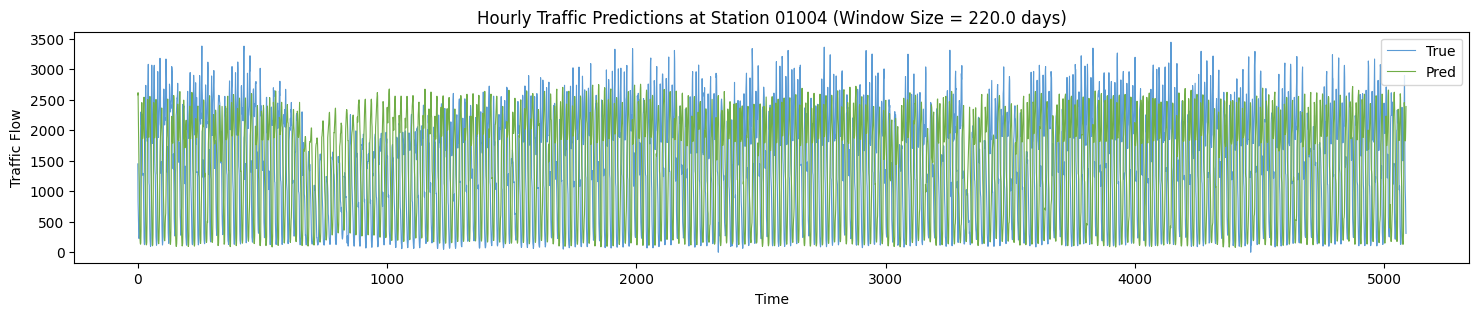

In [ ]:
idx = 0
w = 220*24

plt.figure(figsize = (18, 3))
plt.plot(trues[-w:,idx], label = 'True', color = '#5B9BD5', linewidth = 0.8)
plt.plot(preds[-w:,idx], label = 'Pred', color = '#70AD47', linewidth = 0.8)
plt.xlabel('Time')
plt.ylabel('Traffic Flow')
plt.title('Hourly Traffic Predictions at Station {} (Window Size = {} days)'.format(station_id[idx], w/24))
plt.legend()

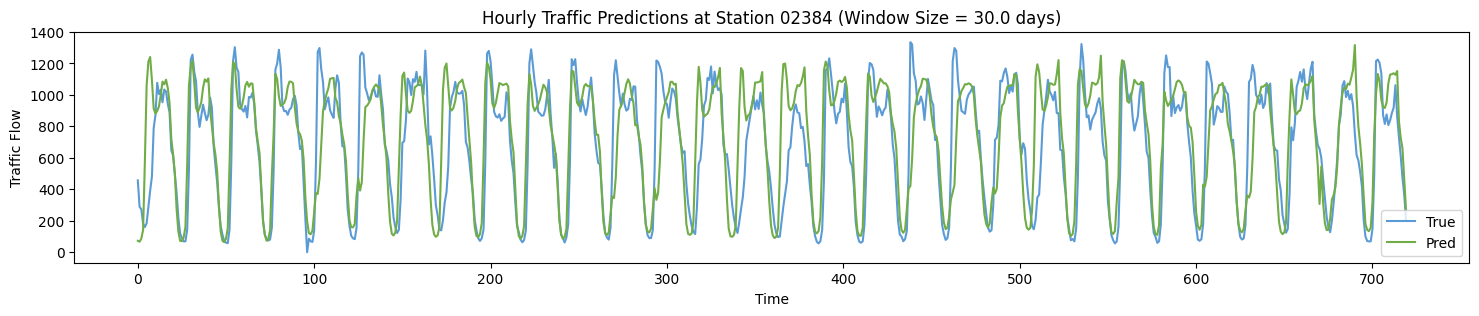

In [ ]:
idx = 1
w = 30*24

plt.figure(figsize = (18, 3))
plt.plot(trues[-w:,idx], label = 'True', color = '#5B9BD5')
plt.plot(preds[-w-15:-15,idx], label = 'Pred', color = '#70AD47')
plt.xlabel('Time')
plt.ylabel('Traffic Flow')
plt.title('Hourly Traffic Predictions at Station {} (Window Size = {} days)'.format(station_id[idx], w/24))
plt.legend()

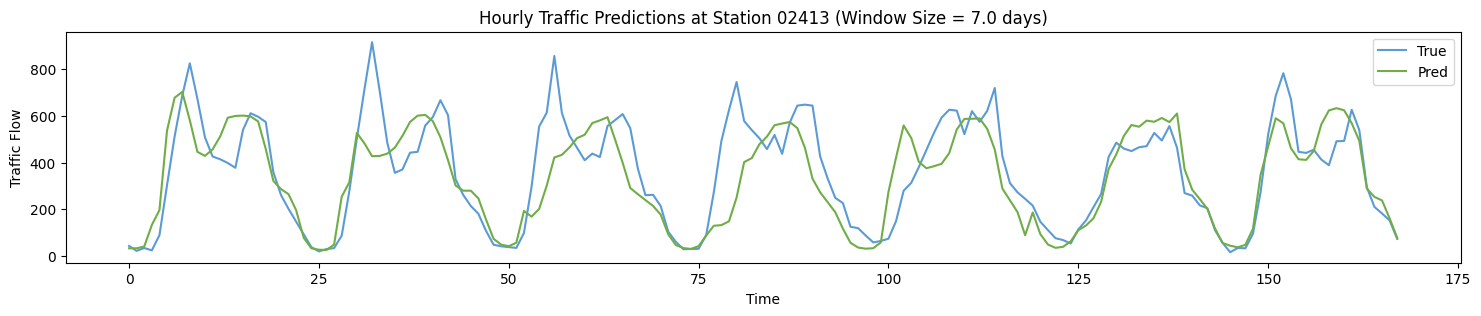

In [ ]:
idx = 2
w = 7*24

plt.figure(figsize = (18, 3))
plt.plot(trues[-w:,idx], label = 'True', color = '#5B9BD5')
plt.plot(preds[-w-15:-15,idx], label = 'Pred', color = '#70AD47')
plt.xlabel('Time')
plt.ylabel('Traffic Flow')
plt.title('Hourly Traffic Predictions at Station {} (Window Size = {} days)'.format(station_id[idx], w/24))
plt.legend()

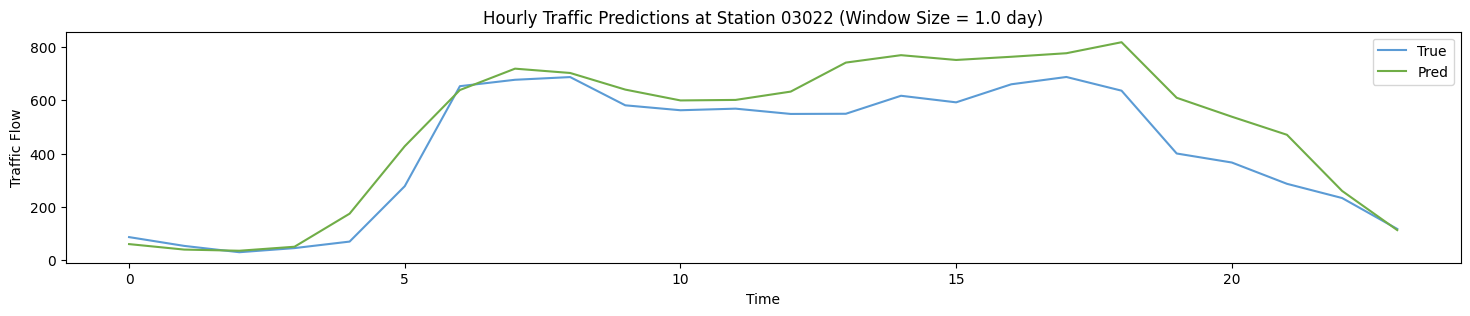

In [ ]:
idx = 3
w = 1*24

plt.figure(figsize = (18, 3))
plt.plot(trues[-w:,idx], label = 'True', color = '#5B9BD5')
plt.plot(preds[-w-15:-15,idx], label = 'Pred', color = '#70AD47')
plt.xlabel('Time')
plt.ylabel('Traffic Flow')
plt.title('Hourly Traffic Predictions at Station {} (Window Size = {} day)'.format(station_id[idx], w/24))
plt.legend()

# **Real-Time Traffic Prediction**

## Load Model and Streamed Data

In [ ]:
model = load_model('/content/drive/MyDrive/Phân tích dữ liệu lớn - DS200.N21/Model/T-GCN-traffic-news-weather')

In [ ]:
seq_len = 7
pre_len = 1
features = 0
batch_size = 64
time_len = 9
n_nodes = 65

In [ ]:
streamed_data = LoadData(path="/content/drive/MyDrive/Phân tích dữ liệu lớn - DS200.N21/Data/Real-time/real_time_node_features.txt",
                      num_nodes=n_nodes,
                      divide_days=[time_len, 0],
                      time_interval=60,
                      seq_len=seq_len,
                      pre_len=pre_len,
                      train_mode="train",
                      features=features,
                      time_len=time_len)

In [ ]:
print(len(streamed_data))
print(streamed_data[0][0].size())
print(streamed_data[0][1].size())

25
torch.Size([65, 168, 28])
torch.Size([65])


In [ ]:
data_loader = DataLoader(streamed_data, batch_size=batch_size, shuffle=False, num_workers=0)
dataGen = DataGenerator(data_loader)

In [ ]:
predictions = model.predict(dataGen)

1/1 [==============================] - 1s 1s/step


In [ ]:
scaler = streamed_data.scaler
predictions = scaler.inverse_transform(predictions)
predictions.shape

(25, 65)

In [ ]:
np.arange(24)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

Text(0.5, 1.0, 'Hourly Traffic Predictions at Station 7168 in 06/07/2022')

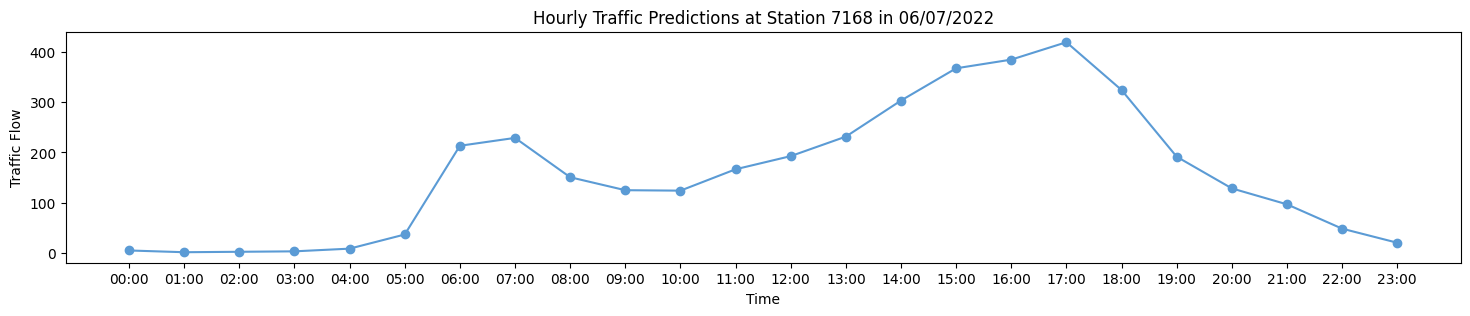

In [ ]:
idx = 45

plt.figure(figsize = (18, 3))
plt.plot(predictions[-24:,idx], color = '#5B9BD5', marker = 'o')
plt.xlabel('Time')
plt.ylabel('Traffic Flow')
plt.xticks(np.arange(24), ['00:00', '01:00', '02:00', '03:00', '04:00', '05:00', '06:00', '07:00', '08:00', '09:00',
                           '10:00', '11:00', '12:00', '13:00', '14:00', '15:00', '16:00', '17:00', '18:00', '19:00', '20:00', '21:00', '22:00', '23:00'])
plt.title('Hourly Traffic Predictions at Station {} in 06/07/2022'.format(station_id[idx]))

In [ ]:
pred_df = pd.DataFrame(predictions[-24:,:], columns = station_id)
pred_df['datetime'] = pd.date_range(start = '2022-07-07 00:00:00', end = '2022-07-07 23:00:00', freq = 'H').strftime("%Y-%m-%d %H:%M:%S")
pred_df = pred_df.set_index('datetime')
pred_df

,01004,02384,02413,03022,100001,10011,19065,22001,22043,24014,...,74229,9658,9827,9834-PR,9836-PR,9849,F3FWY001,T0085,T0231,T0345
datetime,,,,,,,,,,,,,,,,,,,,,
2022-07-07 00:00:00,136.071945,106.074585,34.492607,23.878878,201.537140,219.978134,470.568970,181.095947,10.461883,368.946106,...,38.842598,50.375954,12.803427,8.762472,145.283615,47.873096,120.648483,0.629559,40.087761,3.899130
2022-07-07 01:00:00,68.240852,69.083572,21.637623,5.344219,148.042999,95.751030,189.595901,94.339127,3.580575,193.950714,...,12.763347,18.062401,4.556852,2.575352,52.945171,17.682343,109.951935,0.100164,24.779890,0.579188
2022-07-07 02:00:00,95.291054,98.925644,33.446140,8.973222,192.914658,134.953003,255.325256,122.943626,5.954348,251.471283,...,19.966995,27.546658,7.575249,4.558494,78.508347,27.401785,153.366180,0.216834,35.272724,1.207807
2022-07-07 03:00:00,108.753654,116.893250,43.925686,11.402599,221.321671,162.751190,283.100098,147.256592,8.639801,279.230438,...,24.910200,34.709152,11.444668,6.220486,96.628929,30.151672,201.175995,0.353473,44.017067,2.026163
2022-07-07 04:00:00,178.421494,195.271271,79.105026,26.311863,332.899811,256.651825,443.136871,245.191391,19.472803,404.411316,...,54.346947,63.938618,27.725792,16.394579,180.740356,53.537983,354.005310,1.412038,80.827728,6.837343
2022-07-07 05:00:00,326.654785,343.688934,146.043350,65.871567,617.500916,423.243195,717.819580,549.428833,76.541916,604.112122,...,166.570999,124.980522,101.490906,59.955101,374.776184,111.713608,892.629517,9.266275,205.233826,31.863258
2022-07-07 06:00:00,930.453430,619.334167,252.422348,338.228485,1210.953247,1783.579712,1784.334473,2758.346436,529.728333,1310.946411,...,727.671143,394.554535,545.961609,512.842590,1322.010620,336.854095,1744.716431,104.051849,631.915405,280.947479
2022-07-07 07:00:00,1121.296387,659.028625,237.058624,455.434326,1339.599121,2591.998291,2169.517090,3925.095703,737.261902,1516.046997,...,1020.243042,552.688049,692.884033,724.367615,1618.393433,406.709106,1887.958984,139.492340,731.834534,411.964874
2022-07-07 08:00:00,867.040161,522.818176,146.174850,359.616882,1081.341797,2397.379150,1914.022217,3613.064697,599.302185,1326.519043,...,829.047607,424.798126,552.114502,612.649353,1385.565186,276.036285,1393.646973,80.540375,542.693970,314.966675


In [ ]:
pred_df.to_csv('/content/drive/MyDrive/Phân tích dữ liệu lớn - DS200.N21/Data/predictions.csv')